In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.nn import functional as F

import os
import math
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from PIL import Image
from collections import Counter

# Data

In [2]:
def decode_segmap(image, nc=21):
  
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [3]:
class VOCSegmentation(torch.utils.data.Dataset):
    
    def __init__(self, root, year='2012', transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.year = year
        self.root = os.path.join(root,f'VOCdevkit/VOC{self.year}/')
        
        self.mask_path = os.path.join(self.root,'SegmentationClass')
        
        self.filename = glob(self.mask_path+'/*.png')
        
    def __len__(self):
        return len(self.filename)
        
    def __getitem__(self, idx):
        mask = Image.open(self.filename[idx])
        image = Image.open(self.filename[idx].replace('png','jpg').replace('SegmentationClass','JPEGImages'))
        
        if self.transform:
            image = self.transform(image)
        
        
        if self.target_transform:
            mask = self.target_transform(mask)
        
        mask = np.array(mask)
        mask = np.where(mask==255,0,mask)
        mask = torch.from_numpy(mask)
        
        return image, mask
        

In [4]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [5]:
mask_preprocess = transforms.Compose([
    transforms.Resize((224,224))
])

In [6]:
trainset = VOCSegmentation('../data',transform=preprocess,target_transform=mask_preprocess)

In [7]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4, num_workers=0, shuffle=True)

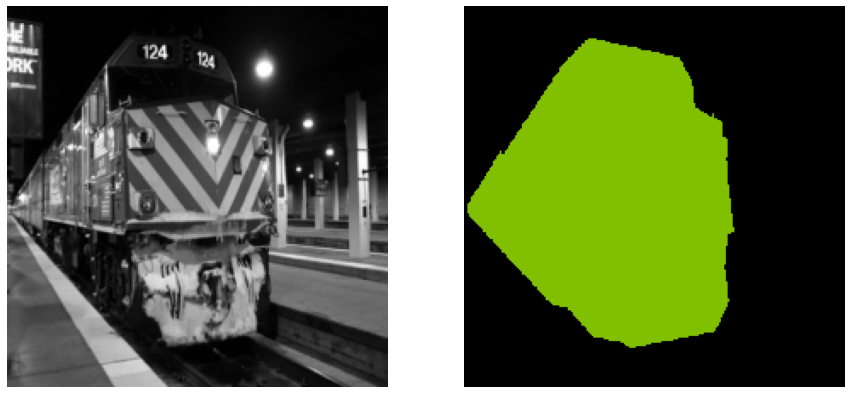

In [42]:
interest_pic = 8
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(trainset[interest_pic][0].permute(1,2,0).numpy())
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(decode_segmap(trainset[interest_pic][1]))

# Model

In [8]:
class DoubleConv(nn.Module):
    
    def __init__(self, in_ch: int, out_ch: int):
        super(DoubleConv,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_ch,out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch,out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        nn.init.normal_(self.model[0].weight,0,math.sqrt(2/9/in_ch))
        nn.init.normal_(self.model[3].weight,0,math.sqrt(2/9/out_ch))
                
    def forward(self, x):
        x = self.model(x)
        return x

In [9]:
class DownSampling(nn.Module):
    
    def __init__(self, in_ch: int, out_ch: int):
        super(DownSampling,self).__init__()
        self.pool = nn.MaxPool2d(2,2)
        self.model = DoubleConv(in_ch, out_ch)
                
    def forward(self, x):
        x = self.pool(x)
        x = self.model(x)
        return x

In [10]:
class UpSampling(nn.Module):
    
    def __init__(self, in_ch: int, out_ch: int):
        super(UpSampling,self).__init__() 
        self.up = nn.ConvTranspose2d(in_ch, int(in_ch/2), 2, stride=2)
        self.model = DoubleConv(in_ch, out_ch)
    
    def forward(self, x: torch.Tensor, feature_map: torch.Tensor) -> torch.Tensor:
        x = self.up(x)
        x_pad, y_pad = feature_map.size(3)-x.size(3), feature_map.size(2)-x.size(2)  
        x = nn.ZeroPad2d((0,0,y_pad//2,x_pad//2))(x)
        c = torch.cat([feature_map,x],dim=1)
        out = self.model(c)
        return out

In [11]:
class UNet(nn.Module):
    
    def __init__(self, n_classes):
        super(UNet,self).__init__()
        self.convhead = DoubleConv(3,64) #64, x
        self.down1 = DownSampling(64,128) #128, x/2
        self.down2 = DownSampling(128,256) #256, x/4
        self.down3 = DownSampling(256,512) #512, x/8
        self.down4 = DownSampling(512,1024) #1024, x/16
        self.up1 = UpSampling(1024,512) #512+512,x/8
        self.up2 = UpSampling(512,256) #256+256,x/4
        self.up3 = UpSampling(256,128) #128+128,x/2
        self.up4 = UpSampling(128,64) #64+64,x
        self.convend = nn.Conv2d(64,n_classes,1) #20, x
    
    def forward(self, x):
        x = self.convhead(x)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        u1 = self.up1(d4,d3)
        u2 = self.up2(u1,d2)
        u3 = self.up3(u2,d1)
        u4 = self.up4(u3,x)
        out = self.convend(u4)
        return out

In [12]:
# test forward
UNet(20+1)(torch.randn(1,3,224,224)).shape

C:\Users\User\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 21, 224, 224])

# training

In [13]:
model = UNet(20+1).cuda()

In [14]:
cls_show = torch.cat([label.unique() for _, label in tqdm(trainset)])

100%|█████████████████████████████████████████████████████████████████████████████| 2913/2913 [00:19<00:00, 149.23it/s]


In [15]:
cls_count = np.array([cls_show.eq(c).sum().item() for c in range(21)])
cls_harmonic = (1/cls_count)/sum(1/cls_count)
cls_freq_inverse = 1/(cls_count/sum(cls_count))

In [16]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(cls_harmonic).float().cuda())
optimizer = torch.optim.Adam(model.parameters())

In [28]:
EPOCHES = 10
acc_iter = 8

In [29]:
model.train()
for e in range(EPOCHES):
    running_loss = 0.0
    count_acc = 0 # gradient accumulation
    optimizer.zero_grad()
    for data in tqdm(trainloader):
        img, label = data
        img = img.cuda()
        label = label.long().cuda()
        
        output = model(img).float()
        loss = criterion(output,label)/acc_iter
        loss.backward()
        count_acc += 1
        
        if count_acc % acc_iter == 0:
            optimizer.step()
            optimizer.zero_grad()
            count_acc = 0
            
        running_loss+=loss.item()
    print(f'epoch {e+1}: {acc_iter*running_loss/len(trainset)}')

  0%|                                                                                          | 0/729 [00:00<?, ?it/s]

epoch 1: 0.6528845501649924


  0%|                                                                                          | 0/729 [00:00<?, ?it/s]

epoch 2: 0.6384208105783302


  0%|                                                                                          | 0/729 [00:00<?, ?it/s]

epoch 3: 0.6256261290940803


  0%|                                                                                          | 0/729 [00:00<?, ?it/s]

epoch 4: 0.6154261654363724


  0%|                                                                                          | 0/729 [00:00<?, ?it/s]

epoch 5: 0.6060696655313379


  0%|                                                                                          | 0/729 [00:00<?, ?it/s]

epoch 6: 0.6012342869928519


  0%|                                                                                          | 0/729 [00:00<?, ?it/s]

epoch 7: 0.5900479609148632


  0%|                                                                                          | 0/729 [00:00<?, ?it/s]

epoch 8: 0.5851768160701166


100%|████████████████████████████████████████████████████████████████████████████████| 729/729 [04:36<00:00,  2.63it/s]

epoch 9: 0.5784972137165691


In [39]:
torch.save(model.state_dict(),'unet.pth')

In [14]:
model.load_state_dict(torch.load('unet.pth'))

<All keys matched successfully>

# Prediction

In [34]:
def draw_comparison(pic: torch.Tensor, lab: torch.Tensor, pred: np.ndarray):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('input')
    plt.axis('off')
    plt.imshow(pic.permute(1,2,0).numpy())
    plt.subplot(1,3,2)
    plt.title('label')
    plt.axis('off')
    plt.imshow(decode_segmap(lab.numpy()))
    plt.subplot(1,3,3)
    plt.title('prediction')
    plt.axis('off')
    plt.imshow(decode_segmap(pred))

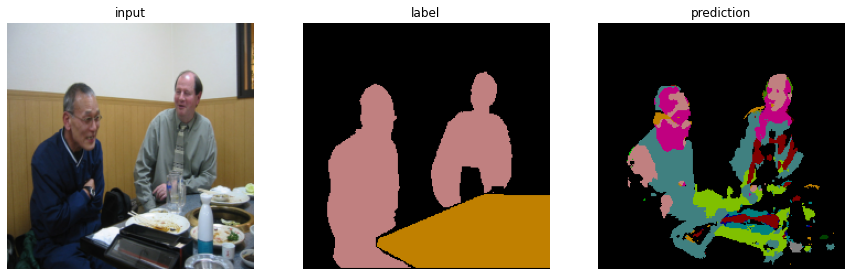

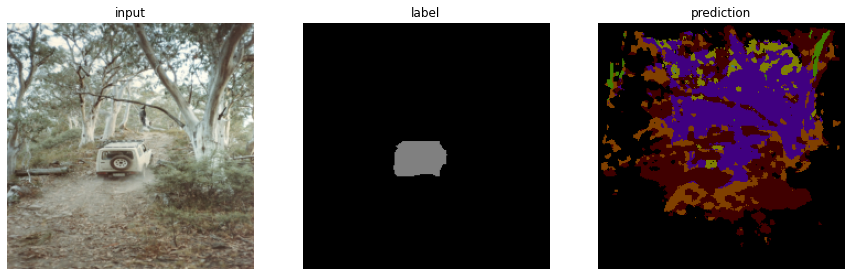

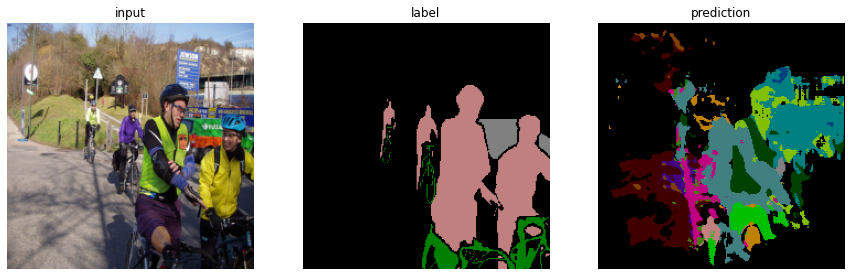

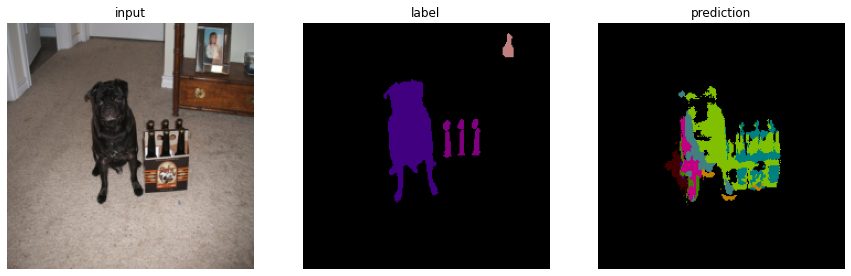

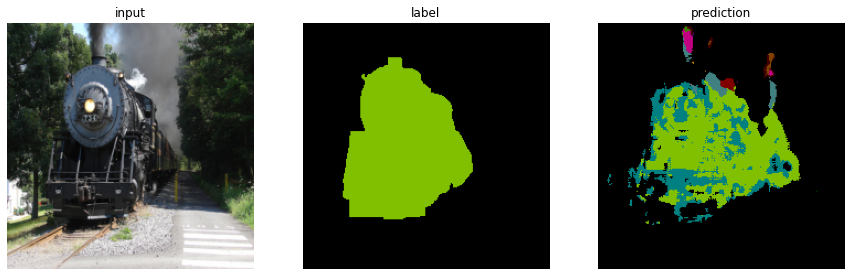

In [46]:
for i in np.random.randint(0,len(trainset),5):
    
    interest_pic, interest_label = trainset[i]

    model.eval()
    with torch.no_grad():
        interest_pic = interest_pic.unsqueeze(0).cuda()
        output = model(interest_pic).squeeze(0).permute(1,2,0).argmax(dim=2).detach().cpu().numpy()
        interest_pic = interest_pic.squeeze(0).detach().cpu()

        draw_comparison(interest_pic, interest_label, output)

比較 FCN

In [11]:
fcn = torchvision.models.segmentation.fcn_resnet50(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to C:\Users\User/.cache\torch\hub\checkpoints\fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

In [32]:
fcn_out = fcn(trainset[8][0].unsqueeze(0))['out'].argmax(dim=1).squeeze(0)

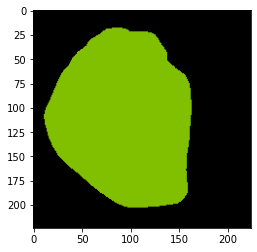

In [33]:
# 一個成功的案例，官方也會失敗 XDD
# one success example, even official failed often lol
plt.imshow(decode_segmap(fcn_out))